# Project: Northwind Product Discount Order-Effect Analysis

The top-level goal of this project is to answer the question:

    Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

Our data set is the Northwind database - a free, open-source dataset created by Microsoft containing data from a fictional company.

## Approach

As is industry standard for Data Science project, I use the OSEMN model:

<p><br>
<img src="https://miro.medium.com/max/3870/1*eE8DP4biqtaIK3aIy1S2zA.png" width="800px">

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, Markdown
import numpy as np
import scjpnlib.utils as scjpnutils
from scjpnlib.utils import sql_manager as sqlmgr
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set()

<p><br><br>

## Obtain the data

Luckily, the data has already been gathered for us and is in `Northwind_small.sqlite`, a sqlite database file.

The project is based on the data set in this database.

Normally from here we would move on to EDA and scrubbing the data.  But before doing so blindly, let's define the scope in order to focus on the goal of the project.

<br><br>

## Define scope of analysis and build hypotheses
Again, the goal of the project is to answer the question:

    Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

So let's formulate our initial hypotheses and determine what tables/columns are involved to that end.  If we can limit our scope up front, that should reduce the potential complexity involved in the traditional EDA and data-scrubbing phase.  But, in order to understand the scope involved, we need to have a clear understanding of our hypotheses.

The hypotheses are nearly generated for us in the problem statement.  We just need to formalize them mathematically.

Looking at the ERD will help us to better understand the details.

<img src="Northwind_ERD_updated.png">


One point of clarification is that a discount is applied to an entire order (when granted), not an individual product.  So we need to find the set of all unique products over all orders that have been discounted. In this manner, we can partition the data.

<p><br>

It is clear from the ERD above that we can restrict our scope to the OrderDetail table in order to answer the goal-question.

But, in order to provide an answer to our goal-question, we need to find a basis for comparison.  The basis is, of course, records in OrderDetail where Discount = 0 versus those where Discount > 0.  

So, we need to first construct the set of unique products over all orders that have had a discount applied.  Let's call this set of unique products appearing on orders that have had a discount applied, $D$.

Taking a microscopic view of the problem, given $D$, for each product, $p \in D$, label the mean quantity of that product ordered with and without a discount applied to orders in which product $p$ appears, thusly:

1. $\mu_p$ is the mean of all quantities of product $p$ appearing on orders WITHOUT a discount
2. $\mu_p^*$ is the mean of all quantities of product $p$ appearing on orders WITH a discount

Then, on a product-by-product basis, our null hypothesis is:

$H_0$: $\mu_p^* = \mu_p$.

And, again on a product-by-product basis, our alternate hypothesis is:

$H_a$: $\mu_p^* > \mu_p$.

But we want a cumulative idea of the effect of the discount, not on a product-by-product basis.

<p><br><br>
So, we redefine our hypotheses as follows:

1. let $\mu$ denote the mean of the sum of quantities of all product $p \in D$ appearing on orders WITHOUT a discount
2. let $\mu_d$ denote the mean of the sum of quantities of all product $p \in D$ appearing on orders WITH a discount

Then our null hypothesis is:

$H_0$: $\mu_d = \mu$.

And our alternate hypothesis is:

$H_a$: $\mu_d > \mu$.

<br>

$\alpha=0.05$

<br><br>

Our immediate goal is to get a set of OrderDetail records.  But the first thing we need to do is...

<p><br>

### Import data set from sqlite database file

In [2]:
# import the data set from sqlite database
nwsqlitedbmgr = sqlmgr.SQLiteDBManager('Northwind_small.sqlite')

Then...

<p><br>

### Load all tables into data frames for ease of manipulation

In [3]:
cur = nwsqlitedbmgr.new_cursor()
result = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
table_names = sorted(list(zip(*result))[0])
cur.close()
table_as_df = dict()
for tn in table_names:
    table_as_df[tn] = nwsqlitedbmgr.sql_query_to_df(f"SELECT * FROM [{tn}]")

Let's have an initial high-level look at what our data looks like.

<p><br>

### High-level Summary of data set

In [4]:
tables_with_nulls = []
for tn, tbl_df in table_as_df.items():
    display(HTML(f"Table <b>{tn}</b>:"))
    cols_with_nulls = scjpnutils.summarize_df(tbl_df)
    if len(cols_with_nulls) > 0:
        tables_with_nulls.append(tn)
    display(HTML(f"<p><br><br>"))

if len(tables_with_nulls) > 0:
    display(HTML(f"<h3>Tables with null values:</h3>"))
    print(tables_with_nulls)

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, and seasonings"
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            8 non-null      int64 
 1   CategoryName  8 non-null      object
 2   Description   8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            91 non-null     object
 1   CompanyName   91 non-null     object
 2   ContactName   91 non-null     object
 3   ContactTitle  91 non-null     object
 4   Address       91 non-null     object
 5   City          91 non-null     object
 6   Region        91 non-null     object
 7   PostalCode    90 non-null     object
 8   Country       91 non-null     object
 9   Phone         91 non-null     object
 10  Fax           69 non-null     object
dtypes: object(11)
memory usage: 7.9+ KB


,Id,CustomerTypeId


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              0 non-null      object
 1   CustomerTypeId  0 non-null      object
dtypes: object(2)
memory usage: 0.0+ bytes


,Id,CustomerDesc


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            0 non-null      object
 1   CustomerDesc  0 non-null      object
dtypes: object(2)
memory usage: 0.0+ bytes


,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Colorado State University in 1970. She also completed 'The Art of the Cold Call.' Nancy is a member of Toastmasters International.,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,"Andrew received his BTS commercial in 1974 and a Ph.D. in international marketing from the University of Dallas in 1981. He is fluent in French and Italian and reads German. He joined the company as a sales representative, was promoted to sales manager in January 1992 and to vice president of sales in March 1993. Andrew is a member of the Sales Management Roundtable, the Seattle Chamber of Commerce, and the Pacific Rim Importers Association.",NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston College (1984). She has also completed a certificate program in food retailing management. Janet was hired as a sales associate in 1991 and promoted to sales representative in February 1992.,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from Concordia College (1958) and an MA from the American Institute of Culinary Arts (1966). She was assigned to the London office temporarily from July through November 1992.,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,"Steven Buchanan graduated from St. Andrews University, Scotland, with a BSC degree in 1976. Upon joining the company as a sales representative in 1992, he spent 6 months in an orientation program at the Seattle office and then returned to his permanent post in London. He was promoted to sales manager in March 1993. Mr. Buchanan has completed the courses 'Successful Telemarketing' and 'International Sales Management.' He is fluent in French.",2.0,http://accweb/emmployees/buchanan.bmp


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               9 non-null      int64  
 1   LastName         9 non-null      object 
 2   FirstName        9 non-null      object 
 3   Title            9 non-null      object 
 4   TitleOfCourtesy  9 non-null      object 
 5   BirthDate        9 non-null      object 
 6   HireDate         9 non-null      object 
 7   Address          9 non-null      object 
 8   City             9 non-null      object 
 9   Region           9 non-null      object 
 10  PostalCode       9 non-null      object 
 11  Country          9 non-null      object 
 12  HomePhone        9 non-null      object 
 13  Extension        9 non-null      object 
 14  Photo            0 non-null      object 
 15  Notes            9 non-null      object 
 16  ReportsTo        8 non-null      float64
 17  PhotoPath        9 n

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           49 non-null     object
 1   EmployeeId   49 non-null     int64 
 2   TerritoryId  49 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              830 non-null    int64  
 1   CustomerId      830 non-null    object 
 2   EmployeeId      830 non-null    int64  
 3   OrderDate       830 non-null    object 
 4   RequiredDate    830 non-null    object 
 5   ShippedDate     809 non-null    object 
 6   ShipVia         830 non-null    int64  
 7   Freight         830 non-null    float64
 8   ShipName        830 non-null    object 
 9   ShipAddress     830 non-null    object 
 10  ShipCity        830 non-null    object 
 11  ShipRegion      830 non-null    object 
 12  ShipPostalCode  811 non-null    object 
 13  ShipCountry     830 non-null    object 
dtypes: float64(1), int64(3), object(10)
memory usage: 90.9+ KB


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         2155 non-null   object 
 1   OrderId    2155 non-null   int64  
 2   ProductId  2155 non-null   int64  
 3   UnitPrice  2155 non-null   float64
 4   Quantity   2155 non-null   int64  
 5   Discount   2155 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               77 non-null     int64  
 1   ProductName      77 non-null     object 
 2   SupplierId       77 non-null     int64  
 3   CategoryId       77 non-null     int64  
 4   QuantityPerUnit  77 non-null     object 
 5   UnitPrice        77 non-null     float64
 6   UnitsInStock     77 non-null     int64  
 7   UnitsOnOrder     77 non-null     int64  
 8   ReorderLevel     77 non-null     int64  
 9   Discontinued     77 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 4 non-null      int64 
 1   RegionDescription  4 non-null      object
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           3 non-null      int64 
 1   CompanyName  3 non-null      object
 2   Phone        3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            29 non-null     int64 
 1   CompanyName   29 non-null     object
 2   ContactName   29 non-null     object
 3   ContactTitle  29 non-null     object
 4   Address       29 non-null     object
 5   City          29 non-null     object
 6   Region        29 non-null     object
 7   PostalCode    29 non-null     object
 8   Country       29 non-null     object
 9   Phone         29 non-null     object
 10  Fax           13 non-null     object
 11  HomePage      5 non-null      object
dtypes: int64(1), object(11)
memory usage: 2.8+ KB


,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Id                    53 non-null     object
 1   TerritoryDescription  53 non-null     object
 2   RegionId              53 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ KB


['Customer', 'Employee', 'Order', 'Supplier']


<br><br>

### Limit data to scope defined by our hypotheses

This is quite simply.  For this analysis, all the data we require is sourced from the **OrderDetail** table.

In [5]:
pysqldfmgr = sqlmgr.PySQLDFManager(globals())

order_detail_df = table_as_df['OrderDetail']
order_detail_df = pysqldfmgr.pysqldf("SELECT * FROM order_detail_df GROUP BY Id")

<br><br>
## Clean Null Values (if necessary)

In [6]:
for nv_tn in tables_with_nulls:
    cwnv_df = scjpnutils.cols_with_nulls(table_as_df[nv_tn])
    display(HTML(f"Columns with null values in table <b>{nv_tn}</b>:<br>"))
    scjpnutils.print_df(cwnv_df)
    display(HTML("<br><br>"))

,name,index,dtype,n_null
0,PostalCode,7,object,1
1,Fax,10,object,22


,name,index,dtype,n_null
0,Photo,14,object,9
1,ReportsTo,16,float64,1


,name,index,dtype,n_null
0,ShippedDate,5,object,21
1,ShipPostalCode,12,object,19


,name,index,dtype,n_null
0,Fax,10,object,16
1,HomePage,11,object,24


<h4>We see that since no column above has any impact on the goal of our analysis effort, THERE IS NO NEED TO FIGURE OUT A NULL-VALUE REPLACEMENT HEURISTIC.</h4>

Now we can move on to...

## Investigate and handle potential outlier values

A boxplot will give us a visual feel for any potential outliers of Quantity, grouped by Discount.

The mean Discount is also shown below.  This is done to highlight that its value will be affected by the presence of outliers (if any).

In [7]:
def boxplot_od_qty_outliers(od_df, prior_mean_qty=None):
    fig = plt.figure(figsize=(12,10))
    sns.boxplot(od_df.Discount, od_df.Quantity) # groups x-axis by unique vals
    mean_qty = od_df.Quantity.mean()
    if prior_mean_qty is None:
        plt.axhline(y=mean_qty, color="red", label=f"mean Quantity ({round(mean_qty,2)})")
    else:
        plt.axhline(y=prior_mean_qty, color="red", label=f"original mean Quantity ({round(prior_mean_qty,2)})")
        plt.axhline(y=mean_qty, color="blue", label=f"new mean Quantity ({round(mean_qty,2)})")
    plt.legend()
    plt.title("Quantity Value Outlier Analysis")
    fig.tight_layout()
    plt.show();

#     fig = plt.figure(figsize=(12,10))
#     sm.graphics.qqplot(od_df.Quantity, dist=stats.norm, line='45', fit=True)
#     fig.tight_layout()
#     plt.show();

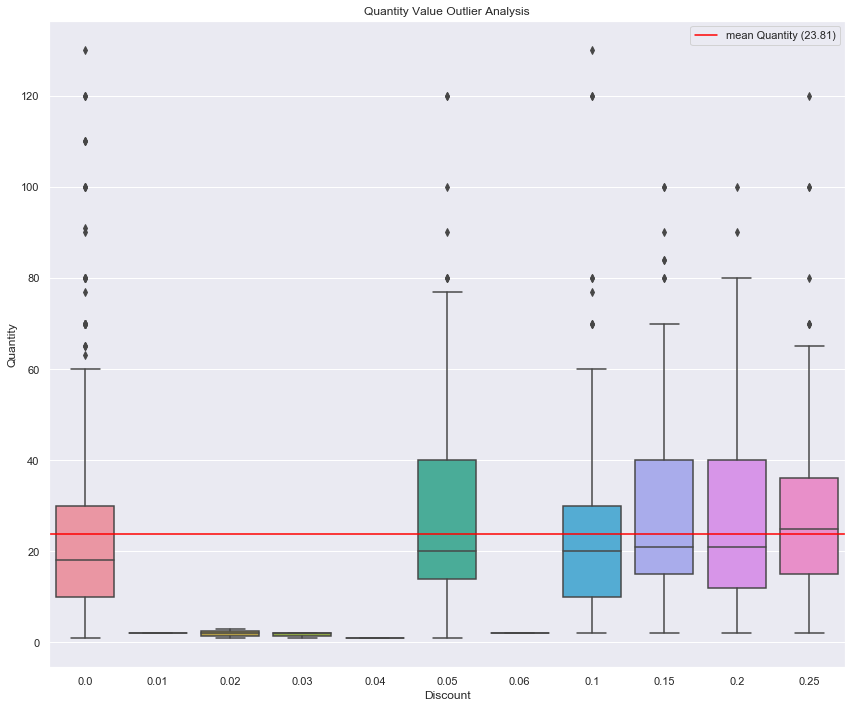

In [8]:
boxplot_od_qty_outliers(order_detail_df)

old_mean_qty = order_detail_df.Quantity.mean()

There are a couple of things to note from the above.

1. We do see the presence of outliers (outside of the whiskers) in Discount bins \[0.0, 0.05, 0.1, 0.15, 0.2, 0.25\]; since they are "above" they will pull the mean Quantity "up".
2. The range of Quanities in the \[0.01, 0.02, 0.03, 0.04, 0.06\] Discount bins are nominal at best; they will pull the mean Quantity "down".

Our first sub-goal is to deal with the above in order to get a better measure of mean Quantity since our hypotheses depend on it.

First, we need to precisely identify outliers in each bin.

We can do this by utilizing the IQR of Quantity values for each binned Discount.

In [9]:
type_1_outlier_discount = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
type_2_outlier_discount = [0.01, 0.02, 0.03, 0.04, 0.06]

Let's drop "type 2" outliers first...

In [10]:
n_total_dropped = 0

order_detail_qty_outliers_removed_df = order_detail_df.copy()
for d_outlier in type_2_outlier_discount:
    len_before_drop = len(order_detail_qty_outliers_removed_df)
    df_outliers = order_detail_df.query(f"Discount=={d_outlier}")
    order_detail_qty_outliers_removed_df = order_detail_qty_outliers_removed_df.drop(df_outliers.index)
    len_after_drop = len(order_detail_qty_outliers_removed_df)
    n_dropped = len_before_drop - len_after_drop
    n_total_dropped += n_dropped
    print(f"dropped {n_dropped} records for Discount value {d_outlier}")
#print(f"\ndropped {n_total_dropped} total outlier observations (including outlier Quantities)")

dropped 1 records for Discount value 0.01
dropped 2 records for Discount value 0.02
dropped 3 records for Discount value 0.03
dropped 1 records for Discount value 0.04
dropped 1 records for Discount value 0.06


In [11]:
# find outlier values of Quantity based on its IQR for each Discount
def get_qty_outlier_vals_by_discount(s_order_detail_df_name, check_discounts=None):
    qty_outliers_for_discount = {}
    if check_discounts is None:
        df_distinct_discounts = pysqldfmgr.pysqldf(f"SELECT DISTINCT Discount FROM {s_order_detail_df_name} ORDER BY Discount ASC")
        check_discounts = list(df_distinct_discounts.Discount.unique())
    for d in check_discounts:
        # get the quantities for this discount and also sort ascending
        df_q = pysqldfmgr.pysqldf(f"SELECT ProductId, Quantity, Discount FROM {s_order_detail_df_name} WHERE Discount={d} ORDER BY Quantity ASC")
        
        q1, q3 = np.percentile(df_q.Quantity, [25, 75])
        delta = q3 - q1
        iqr_q_lb = q1 - (1.5 * delta) 
        iqr_q_ub = q3 + (1.5 * delta)

        df_q_outliers_for_d = pysqldfmgr.pysqldf(f"""
            SELECT ProductId, Quantity, Discount 
            FROM {s_order_detail_df_name} 
            WHERE Discount={d} AND (Quantity < {iqr_q_lb} OR Quantity > {iqr_q_ub})
        """)

        q_outliers_for_d = sorted(list(df_q_outliers_for_d.Quantity.unique()))
        display(HTML(f"Outlier values for <b>Quantity</b> (IQR lb: {iqr_q_lb}, IQR ub: {iqr_q_ub}) for discount={d}: {q_outliers_for_d}"))
        qty_outliers_for_discount[d] = q_outliers_for_d
    print()
    return qty_outliers_for_discount

# this function will handle a set of outlier values by passing in a callback
#    the specific manner in which outliers are handled is defined by the callback function
def handle_qty_outliers(order_detail_df, qty_outliers_for_discount, f_outliers_df_index_handler, kwargs=None):
    for d, q_outliers_for_d in qty_outliers_for_discount.items():
        for q_outlier in q_outliers_for_d:
            #find records with outlier qty value for this discount
            df_outliers = order_detail_df.query(f"(Discount=={d}) & (Quantity=={q_outlier})")
            order_detail_df = f_outliers_df_index_handler(order_detail_df, d, q_outlier, df_outliers.index, kwargs)
    return order_detail_df

# this handler is passed to handle_qty_outliers()
#   it will drop records from the index resulting from finding Quatity outliers in handle_qty_outliers()
def drop_index_handler(order_detail_df, d, q_outlier, df_outliers_index, kwargs):
    len_before_drop = len(order_detail_df)
    order_detail_df = order_detail_df.drop(df_outliers_index)
    len_after_drop = len(order_detail_df)
    n_dropped = len_before_drop - len_after_drop
    print(f"dropped {n_dropped} records for Discount value {d} with outlier Quantity value {q_outlier}")
    return order_detail_df

def drop_qty_outlier_vals_by_discount(s_od_df_name, lst_discounts_with_outliers=None, display_box_plot=True, original_mean=None):
    od_df = globals()[s_od_df_name]
    len_before = len(od_df)
    
    # now call handle_qty_outliers(), passing in drop_index_handler() to drop qualifying records
    #   the resulting DF is saved to a new DF
    od_qty_outliers_removed_df = handle_qty_outliers(
        od_df.copy()
        , get_qty_outlier_vals_by_discount(s_od_df_name, lst_discounts_with_outliers)
        , drop_index_handler
    )

    # print the results
    len_after = len(od_qty_outliers_removed_df)
    n_total_dropped = len_before - len_after
    print(f"\ndropped {n_total_dropped} total outlier observations")
    
    if display_box_plot:
        display(Markdown("<br>Now let's have a look at a new boxplot after removing outliers and compare the new mean Quantity to the old..."))
        boxplot_od_qty_outliers(od_qty_outliers_removed_df, original_mean if original_mean is not None else od_df.Quantity.mean())
    
    return (n_total_dropped, od_qty_outliers_removed_df)

Now remove "type 1" outliers...


dropped 1 records for Discount value 0.0 with outlier Quantity value 63
dropped 3 records for Discount value 0.0 with outlier Quantity value 65
dropped 10 records for Discount value 0.0 with outlier Quantity value 70
dropped 1 records for Discount value 0.0 with outlier Quantity value 77
dropped 6 records for Discount value 0.0 with outlier Quantity value 80
dropped 1 records for Discount value 0.0 with outlier Quantity value 90
dropped 1 records for Discount value 0.0 with outlier Quantity value 91
dropped 4 records for Discount value 0.0 with outlier Quantity value 100
dropped 3 records for Discount value 0.0 with outlier Quantity value 110
dropped 3 records for Discount value 0.0 with outlier Quantity value 120
dropped 1 records for Discount value 0.0 with outlier Quantity value 130
dropped 3 records for Discount value 0.05 with outlier Quantity value 80
dropped 1 records for Discount value 0.05 with outlier Quantity value 90
dropped 1 records for Discount value 0.05 with outlier Q

<br>Now let's have a look at a new boxplot after removing outliers and compare the new mean Quantity to the old...

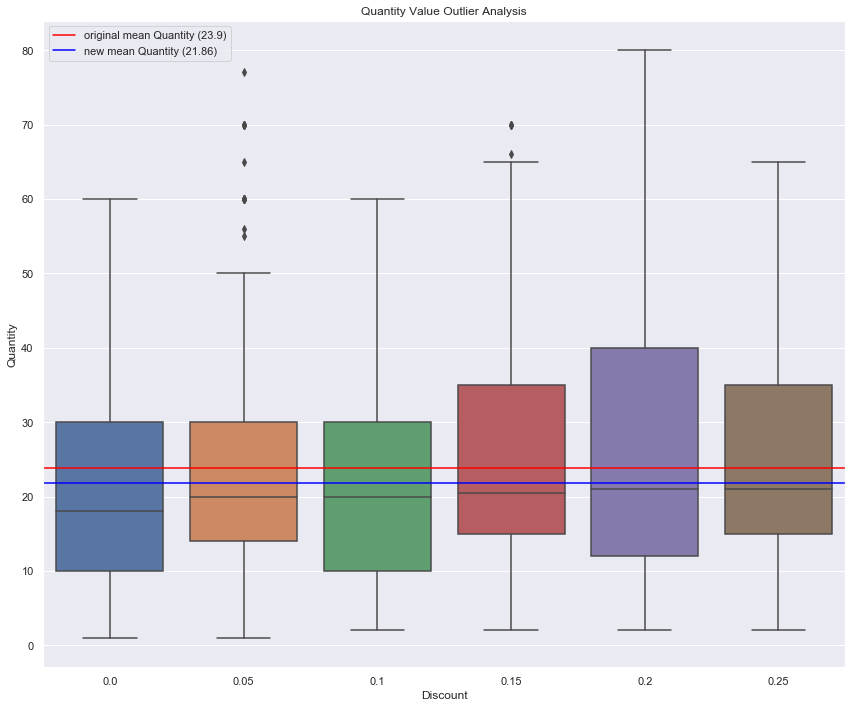

In [12]:
n_total_dropped, order_detail_qty_outliers_removed_df = drop_qty_outlier_vals_by_discount('order_detail_qty_outliers_removed_df', type_1_outlier_discount)

It appears that addressing the former outliers was effective, as the mean has dropped by roughly by 10% of its former value.

But let's formalize this via ***Cohen's D***.

In [13]:
# borrowed directly from corresponding lesson on Learn
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

In [14]:
cd = Cohen_d(order_detail_df.Quantity, order_detail_qty_outliers_removed_df.Quantity)
cd

0.11389943135244662

The effect size of removing outliers is small but not insignificant.

One thing to note from the above boxplot is that some (new) outliers appear for Discount = 0.05 and Discount = 0.15.

Let's determine if it's worth pursuing another round of outlier-cleanup...

In [15]:
type_1_outlier_discount = [0.05, 0.15]
qty_outliers_for_discount = get_qty_outlier_vals_by_discount('order_detail_qty_outliers_removed_df', type_1_outlier_discount)
d_kwargs = {'n_outliers_remaining':0}

def count_index_handler(order_detail_df, d, q_outlier, df_outliers_index, kwargs):
    n_records = len(order_detail_df.loc[df_outliers_index])
    print(f"there are {n_records} records with Quantity outlier value {q_outlier} for discount {d}")
    kwargs['n_outliers_remaining'] += n_records
    return order_detail_df

handle_qty_outliers(
    order_detail_qty_outliers_removed_df
    , qty_outliers_for_discount
    , count_index_handler
    , d_kwargs
)
print(f"\nthere are {d_kwargs['n_outliers_remaining']} total Quantity outlier records remaining out of {len(order_detail_qty_outliers_removed_df)} total records")


there are 1 records with Quantity outlier value 55 for discount 0.05
there are 1 records with Quantity outlier value 56 for discount 0.05
there are 9 records with Quantity outlier value 60 for discount 0.05
there are 1 records with Quantity outlier value 65 for discount 0.05
there are 6 records with Quantity outlier value 70 for discount 0.05
there are 1 records with Quantity outlier value 77 for discount 0.05
there are 1 records with Quantity outlier value 66 for discount 0.15
there are 4 records with Quantity outlier value 70 for discount 0.15

there are 24 total Quantity outlier records remaining out of 2081 total records


24/2081 doesn't seem worth the effort - we don't want to drop too many records.

Plus, it is possible that doing another round of IQR-outlier analysis will yield yet new outliers.

But just for giggles, let's remove these outliers and save to a new DF so that we can generate a new effect size and compare it to the last one.


dropped 1 records for Discount value 0.05 with outlier Quantity value 55
dropped 1 records for Discount value 0.05 with outlier Quantity value 56
dropped 9 records for Discount value 0.05 with outlier Quantity value 60
dropped 1 records for Discount value 0.05 with outlier Quantity value 65
dropped 6 records for Discount value 0.05 with outlier Quantity value 70
dropped 1 records for Discount value 0.05 with outlier Quantity value 77
dropped 1 records for Discount value 0.15 with outlier Quantity value 66
dropped 4 records for Discount value 0.15 with outlier Quantity value 70

dropped 24 total outlier observations


<br>Now let's have a look at a new boxplot after removing outliers and compare the new mean Quantity to the old...

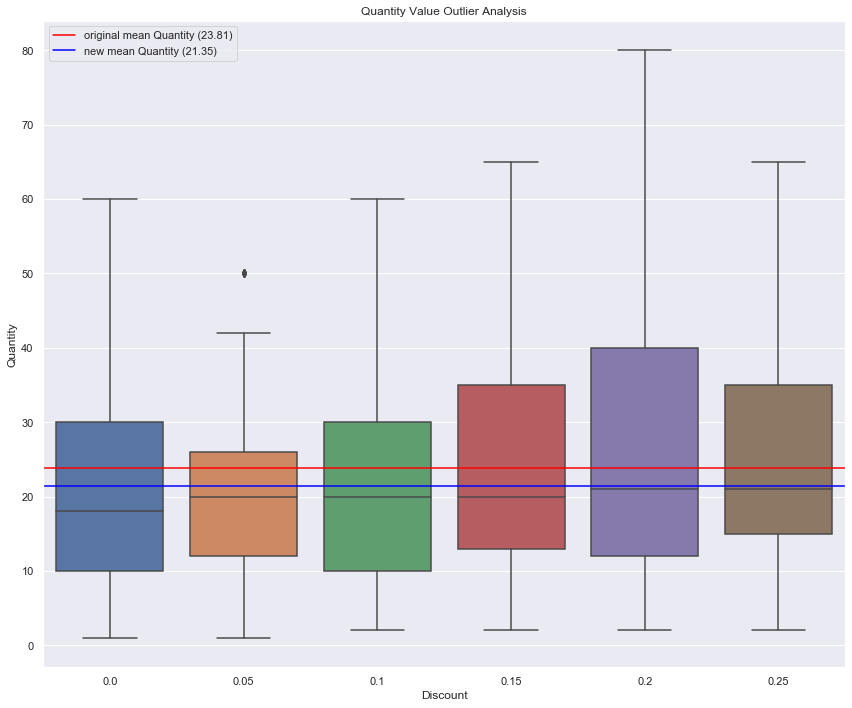

In [16]:
n_total_dropped, order_detail_qty_outliers_removed_df_2 = drop_qty_outlier_vals_by_discount(
    'order_detail_qty_outliers_removed_df'
    , type_1_outlier_discount
    , display_box_plot=True
    , original_mean=order_detail_df.Quantity.mean()
)

In [17]:
# compute Cohen's D again, comparing to original data set
cd2 = Cohen_d(order_detail_df.Quantity, order_detail_qty_outliers_removed_df_2.Quantity)
display(Markdown(f"***Cohen's D*** of Quantity (comparing the original data to this one) is: {cd2}"))

***Cohen's D*** of Quantity (comparing the original data to this one) is: 0.14545578161886077

Committing to the data set above after a second recond of outlier-cleanup might be worth it if the effect size surpassed .2.

But, since it doesn't, we will stick with what we have.

Let's summarize the results of our committed outlier-cleanup...

In [18]:
n_start = len(order_detail_df)
n_end = len(order_detail_qty_outliers_removed_df)
n_dropped = n_start - n_end

d_kwargs['n_outliers_remaining'] = 0
handle_qty_outliers(
    order_detail_qty_outliers_removed_df
    , get_qty_outlier_vals_by_discount('order_detail_qty_outliers_removed_df')
    , count_index_handler
    , d_kwargs
)

print(f"\ndropping {n_dropped} observations with outlier Quantity values from {n_start} starting observations yields an effect size of {cd} with {d_kwargs['n_outliers_remaining']}/{n_end} outliers remaining")


there are 1 records with Quantity outlier value 55 for discount 0.05
there are 1 records with Quantity outlier value 56 for discount 0.05
there are 9 records with Quantity outlier value 60 for discount 0.05
there are 1 records with Quantity outlier value 65 for discount 0.05
there are 6 records with Quantity outlier value 70 for discount 0.05
there are 1 records with Quantity outlier value 77 for discount 0.05
there are 1 records with Quantity outlier value 66 for discount 0.15
there are 4 records with Quantity outlier value 70 for discount 0.15

dropping 74 observations with outlier Quantity values from 2155 starting observations yields an effect size of 0.11389943135244662 with 24/2081 outliers remaining


This is definitely acceptable.

At this point, we have done all the work necessary in order to scrub **OrderDetail** data.

Let's move on...

<br><br>

## Partition data into subsets with Discount == 0 and Discount > 0 and consider only those products appearing on discounted orders

We want to compare apples to apples, here.

So, in addition to partitioning based on whether an order has a **Discount** or not, we will also consider only those non-discounted orders containing the same products as those appearing on discounted orders.

In [19]:
orders_with_discount_df = pysqldfmgr.pysqldf(f"SELECT * FROM order_detail_qty_outliers_removed_df WHERE Discount>0")
distinct_discounted_products_df = pysqldfmgr.pysqldf(f"SELECT DISTINCT ProductId FROM orders_with_discount_df")
orders_without_discount_df = pysqldfmgr.pysqldf(f"""
    SELECT * 
    FROM order_detail_qty_outliers_removed_df 
    WHERE Discount=0 AND ProductId IN (SELECT * FROM distinct_discounted_products_df)
""")

# out of curiosity...
# orders_not_discounted_with_products_never_discounted = pysqldfmgr.pysqldf(f"SELECT * FROM order_detail_qty_outliers_removed_df WHERE Discount=0 AND ProductId NOT IN (SELECT * FROM distinct_discounted_products_df)")
# scjpnutils.print_df(orders_not_discounted_with_products_never_discounted)

## Test Hypotheses

We will execute our battery of hypothesis tests against the groups with and without discounts as a whole.

Each of these tests will operate on the mean Quantity.

In [20]:
mu_no_discount = orders_without_discount_df.Quantity.mean()
mu_discount = orders_with_discount_df.Quantity.mean()

display(Markdown(f"$\mu={round(mu_no_discount,2)}$"))
display(Markdown(f"$\mu_d={round(mu_discount,2)}$"))

$\mu=20.02$

$\mu_d=24.81$

Let's have a look at the distributions to get a visual feel for how they match up to the above.

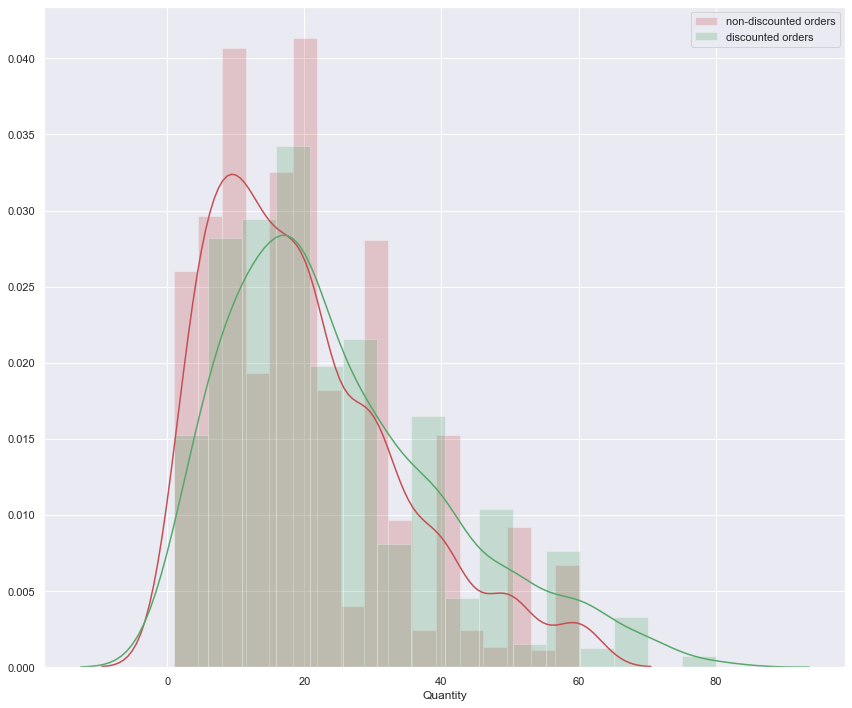

In [21]:
fig = plt.figure(figsize=(12,10))
sns.distplot(orders_without_discount_df.Quantity, hist_kws={'alpha':0.25}, color="r", label="non-discounted orders")
sns.distplot(orders_with_discount_df.Quantity, hist_kws={'alpha':0.25}, color="g", label="discounted orders")
plt.legend()
fig.tight_layout()
plt.show();

Visually speaking, these distributions are clearly not normal.  

Additionally, we can see that **the distribution of Quantity values for products on discounted orders consistently trend to the right a bit more than they do for *the same products* on non-discounted orders**.

### Cohen's D: Measure the effect size of difference in means

In [22]:
Cohen_d(orders_without_discount_df.Quantity, orders_with_discount_df.Quantity)

-0.3224030529118955

Since ***Cohen's D*** is negative, this confirms that indeed $\mu_d > \mu$ and the effect size can be considered moderate.

This ***Cohen's D*** measure seems to be inline with the observations we made visually above.

<br>

### Two-Sample T-Test: used to determine if the means of two samples of equal size and variance are equal

According to the `scipy.stats.ttest_ind` documentation:

    This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

Assumptions made when applying a Two-Sample T-Test:

1. Populations/samples are independent.
2. Sizes of samples are equal.
3. Variances of samples are equal.
4. Distributions are normal.

We would like to apply this test given that our two samples are indeed independent.

But as we saw above, the distributions clearly do not appear to be normal.

So, intution tells us that we cannot apply this test.

But, we want to be thorough, so let's check whether or not our samples *officially* meet the requirements to apply this test.

We'll test for normality first since we already have a visual feel for this result.

<br>

#### Are the distributions of our samples normal?

We will test this by running `scipy.stats.normaltest` on each partition.

**This test (the null hypothesis) assumes that the distribution is NOT normal.**

Thus, if the p-value returned is greater than significance the level (0.05), the null hypothesis is rejected - i.e. the distribution IS normal.

In [23]:
def format_pval_result(p_val, alpha, s):
    return "$p\\_val\\ ({}) {} \\alpha\\ ({}) \\implies$ {}".format(p_val, "<" if p_val < alpha else "\\ge", alpha, s)

In [24]:
alpha = 0.05

sk, p_val = stats.normaltest(orders_without_discount_df.Quantity)
display(Markdown(format_pval_result(p_val, alpha, f"distribution of Quantity values for orders without discounts {'is NOT' if p_val < alpha else 'IS'} normal")))

sk_d, p_val_d = stats.normaltest(orders_with_discount_df.Quantity)
display(Markdown(format_pval_result(p_val_d, alpha, f"distribution of Quantity values for orders WITH discounts {'is NOT' if p_val_d < alpha else 'IS'} normal")))

$p\_val\ (4.404118427297491e-32) < \alpha\ (0.05) \implies$ distribution of Quantity values for orders without discounts is NOT normal

$p\_val\ (1.504198946335853e-19) < \alpha\ (0.05) \implies$ distribution of Quantity values for orders WITH discounts is NOT normal

Therefore, because the distributions of the samples are not normal, we cannot apply the <b><i>Two-sample T-Test</i></b>.

But, for the sake of completeness, let's check the other assumptions.

<br>

#### Are samples the same size?

In [25]:
n_no_discount = len(orders_without_discount_df)
print(f"The set of orders without a discount has {n_no_discount} observations.")
n_discounted = len(orders_with_discount_df)
print(f"The set of orders WITH a discount has {n_discounted} observations.")
display(Markdown(f"<br>Samples are same size? {n_no_discount==n_discounted}"))

The set of orders without a discount has 1283 observations.
The set of orders WITH a discount has 798 observations.


<br>Samples are same size? False

Therefore, because the samples are not the same size, we cannot apply the <b><i>Two-sample T-Test</i></b>.

Again, for the sake of completeness, let's check the other assumptions.

<br>

#### Do the samples have the same variance?

Note that it would likely be naive simply to check for equality of `np.variance` since that does not consider allowing some small error.

Thus, we turn to `scipy.stats.levene` since, according to its documentation:

    The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test in the case where there are significant deviations from normality.
    
And, since we have indeed confirmed (above) that the distributions are not normal, Levene's test is appropriate.

**This test (the null hypothesis) assumes that the samples are NOT from populations with equal variances.**

Just out of curiosity, let's first check using `np.variance`:

In [26]:
v_no_discount = np.var(orders_without_discount_df.Quantity)
print(f"The set of orders without a discount has variance: {v_no_discount}.")
v_discounted = np.var(orders_with_discount_df.Quantity)
print(f"The set of orders WITH a discount has variance: {v_discounted}.")

l_stat, p_val = stats.levene(orders_without_discount_df.Quantity, orders_with_discount_df.Quantity, center='mean')
display(Markdown(format_pval_result(p_val_d, alpha, f"sample {'are NOT' if p_val_d < alpha else 'ARE'} from populations with equal variances.")))

The set of orders without a discount has variance: 192.93108938824088.
The set of orders WITH a discount has variance: 265.5494076670373.


$p\_val\ (1.504198946335853e-19) < \alpha\ (0.05) \implies$ sample are NOT from populations with equal variances.

Therefore, because the samples are NOT from populations with equal variances, we cannot apply the <b><i>Two-sample T-Test</i></b>.

<br><br>

### Welch's Test: used to determine if two sample means with unequal variance are equal

We can pass `equal_var=False` to `scipy.stats.ttest_ind` to perform ***Welch's Test***.

According to the documentation:

    If [equal_var=]False, perform Welch’s t-test, which does not assume equal population variance.
    
As we have seen above, the samples are not from populations with equal variances.

Therefore, it is appropriate to apply ***Welch's Test*** in this case.

In [27]:
t_stat, p_val = stats.ttest_ind(orders_without_discount_df.Quantity, orders_with_discount_df.Quantity, equal_var=False)
# s_md = f"p-val={p_val} $" + ("<" if p_val_d < alpha else "\\ge") + f"{alpha} \\implies \\mu_d " + (">" if p_val_d < alpha else "=") + "\\mu$"
# display(Markdown(s_md))

display(Markdown(format_pval_result(p_val_d, alpha, "$\\mu_d " + (">" if p_val_d < alpha else "=") + "\\mu$.")))

$p\_val\ (1.504198946335853e-19) < \alpha\ (0.05) \implies$ $\mu_d >\mu$.

Thus, with ***Welch's Test***, the null hypothesis is rejected and the alternate hypothesis is accepted.

That is, the hypothesis that **discount amount DOES have a statistically significant effect on the quantity of a product ordered** is accepted.

With this result, we have answered the first part of our goal-question.

Now let's move on to answer the second part:

    If so, at what level(s) of discount?

In [29]:
order_detail_qty_outliers_removed_df.Quantity.groupby(order_detail_qty_outliers_removed_df.Discount).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1283.0,20.017927,13.895380,1.0,10.0,18.0,30.0,60.0
0.05,178.0,25.348315,17.669663,1.0,14.0,20.0,30.0,77.0
0.10,164.0,21.640244,13.892615,2.0,10.0,20.0,30.0,60.0
0.15,150.0,25.586667,16.699149,2.0,15.0,20.5,35.0,70.0
0.20,159.0,26.169811,17.309618,2.0,12.0,21.0,40.0,80.0
0.25,147.0,25.435374,15.294850,2.0,15.0,21.0,35.0,65.0


In [30]:
# this is for combined - i.e. data set includes no discount

q1b_results = ols('Quantity ~ C(Discount)', data=order_detail_qty_outliers_removed_df).fit()
q1b_anova_table = sm.stats.anova_lm(q1b_results, typ=2)
print(q1b_anova_table)

                    sum_sq      df          F        PR(>F)
C(Discount)   13443.060510     5.0  12.199646  1.125178e-11
Residual     457297.691052  2075.0        NaN           NaN


## References

Mason, H., & Wiggins, C. Data Science Process [Image]. Retrieved from https://miro.medium.com/max/3870/1*eE8DP4biqtaIK3aIy1S2zA.png